# Introduction

This notebook explores the relationship between market sentiment and trader behavior using the Fear/Greed index and historical trade data from Hyperliquid. The objective is to understand whether traders perform and behave differently under varying emotional market conditions such as Fear, Greed, Extreme Fear, and Extreme Greed. The analysis focuses on identifying measurable patterns that can lead to practical, data-driven trading insights.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In this section, both datasets are loaded and briefly inspected to understand their structure, column types, and overall size. This helps establish a foundation for the analysis and ensures the data is ready for cleaning and transformation.

In [2]:
# Loading the datasets
fear_greed_data = pd.read_csv("/content/fear_greed_index.csv")
historical_data = pd.read_csv("/content/historical_data.csv")

In [ ]:
fear_greed_data.shape

In [ ]:
historical_data.shape

In [ ]:
fear_greed_data.info()

In [ ]:
historical_data.info()

In [ ]:
fear_greed_data.head()

In [ ]:
historical_data.head()

In [ ]:
fear_greed_data.isnull().sum()

In [ ]:
historical_data.isnull().sum()

In [ ]:
fear_greed_data.duplicated().sum()

In [ ]:
historical_data.duplicated().sum()

# Data Cleaning & Preparation

Before analysis, the datasets are cleaned and standardized. Timestamps are converted into a consistent date format, unnecessary columns are reviewed, and missing or duplicate entries are checked. The two datasets are then aligned and merged on the date field so that each trade is associated with the corresponding market sentiment of that day.

In [26]:
# Convert timestamps and align the datasets by date
fear_greed_data['date'] = pd.to_datetime(fear_greed_data['date']).dt.date
historical_data['date'] = pd.to_datetime(historical_data['date']).dt.date
historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], format="%d-%m-%Y %H:%M")
historical_data['date'] = historical_data['Timestamp IST'].dt.date

In [ ]:
historical_data.head()

In [28]:
merged = historical_data.merge(
    fear_greed_data[['date','classification']],
    on='date',
    how='left'
)

In [ ]:
merged.head()

In [ ]:
merged['classification'].unique()

In [31]:
merged = merged.dropna(subset=['classification'])

In [ ]:
merged.shape

In [ ]:
merged.isnull().sum()

In [ ]:
merged.duplicated().sum()


# Feature Engineering (Key Metrics Creation)

To meaningfully analyze trader behavior, new metrics are created from the raw data. These include performance indicators such as daily PnL and win rate, as well as behavioral indicators like trade frequency, trade size, and total trading volume. These features help quantify how traders act under different sentiment conditions.

In [36]:
# Creating Key Metrics
daily_pnl = merged.groupby(['Account','date'])['Closed PnL'].sum().reset_index()

merged['win'] = merged['Closed PnL'] > 0
win_rate = merged.groupby('Account')['win'].mean()

trades_per_day = merged.groupby('date').size()

In [41]:
avg_trade_size = merged.groupby('Account')['Size USD'].mean().reset_index()
avg_trade_size.rename(columns={'Size USD': 'avg_trade_size_usd'}, inplace=True)

In [43]:
long_short_ratio = merged.groupby(['classification','Side']).size().unstack()

In [44]:
daily_total_pnl = merged.groupby(['date','classification'])['Closed PnL'].sum().reset_index()
trades_per_trader = merged.groupby('Account').size().reset_index(name='trade_count')
# Profit consistency
profit_std = merged.groupby('Account')['Closed PnL'].std().reset_index()
profit_std.rename(columns={'Closed PnL':'pnl_volatility'}, inplace=True)


In [45]:
# Does performance differ in Fear vs Greed?
merged.groupby('classification')['Closed PnL'].mean().sort_values()

,Closed PnL
classification,
Neutral,34.307718
Extreme Fear,34.537862
Greed,42.743559
Fear,54.290400
Extreme Greed,67.892861


In [46]:
merged.groupby('classification')['win'].mean()

,win
classification,
Extreme Fear,0.370607
Extreme Greed,0.464943
Fear,0.420768
Greed,0.384828
Neutral,0.396991


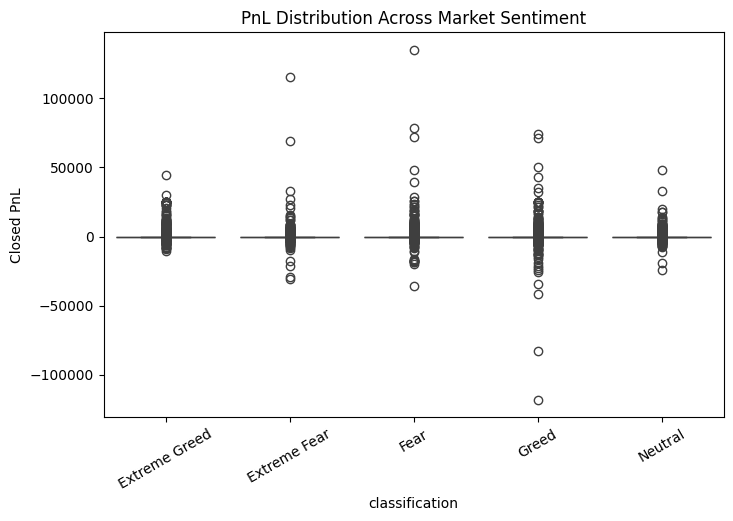

In [47]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='Closed PnL', data=merged)
plt.xticks(rotation=30)
plt.title("PnL Distribution Across Market Sentiment")
plt.show()

# Sentiment vs Performance Analysis

This section examines how trading outcomes vary across sentiment regimes. By comparing PnL, win rates, and activity levels across Fear, Greed, Extreme Fear, Extreme Greed, and Neutral periods, we can observe whether sentiment has a measurable influence on performance.

Average Daily Trade Count by Sentiment:
classification
Extreme Fear     1528.571429
Fear              679.527473
Neutral           562.477612
Extreme Greed     350.807018
Greed             260.637306
Name: daily_trades, dtype: float64


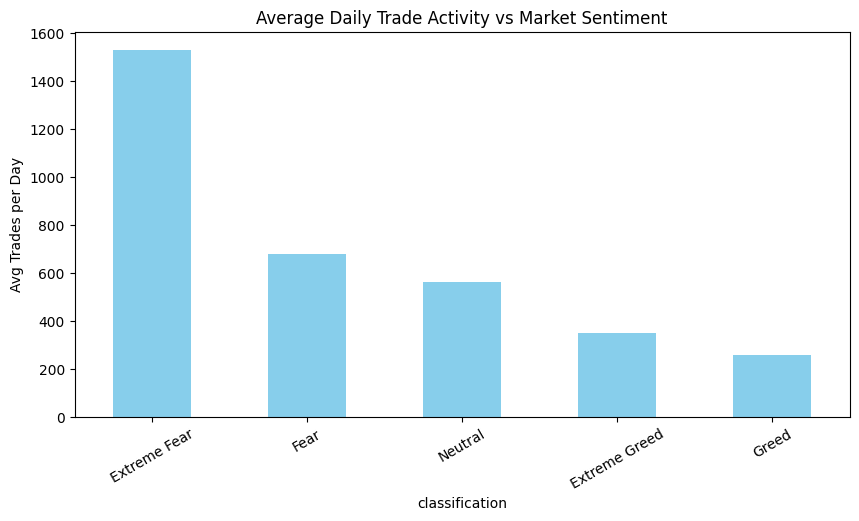

In [63]:
# Do traders change behavior?
# Calculate average trades per day by sentiment to normalize activity
daily_activity = merged.groupby(['date', 'classification']).size().reset_index(name='daily_trades')
avg_daily_activity = daily_activity.groupby('classification')['daily_trades'].mean().sort_values(ascending=False)

print("Average Daily Trade Count by Sentiment:")
print(avg_daily_activity)

# Visualization
plt.figure(figsize=(10,5))
avg_daily_activity.plot(kind='bar', color='skyblue')
plt.title("Average Daily Trade Activity vs Market Sentiment")
plt.ylabel("Avg Trades per Day")
plt.xticks(rotation=30)
plt.show()

In [49]:
merged.groupby('classification')['Size USD'].mean()

,Size USD
classification,
Extreme Fear,5349.731843
Extreme Greed,3112.251565
Fear,7816.109931
Greed,5736.884375
Neutral,4782.732661


In [50]:
merged.groupby(['classification','Side']).size().unstack()

Side,BUY,SELL
classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


# Trader Segmentation

To better understand patterns, traders are grouped into segments based on their activity and performance. This allows comparison between different types of traders, such as high-volume vs low-volume participants, frequent vs casual traders, and profitable vs unprofitable accounts.

In [51]:
volume = merged.groupby('Account')['Size USD'].sum()

high_volume_accounts = volume[volume > volume.median()].index

merged['volume_segment'] = merged['Account'].apply(
    lambda x: 'High Volume' if x in high_volume_accounts else 'Low Volume'
)


Win Rate Analysis by Trader Segment:


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
volume_segment,,,,,
High Volume,0.369923,0.501936,0.428437,0.372295,0.393707
Low Volume,0.374078,0.404580,0.365844,0.424272,0.423721


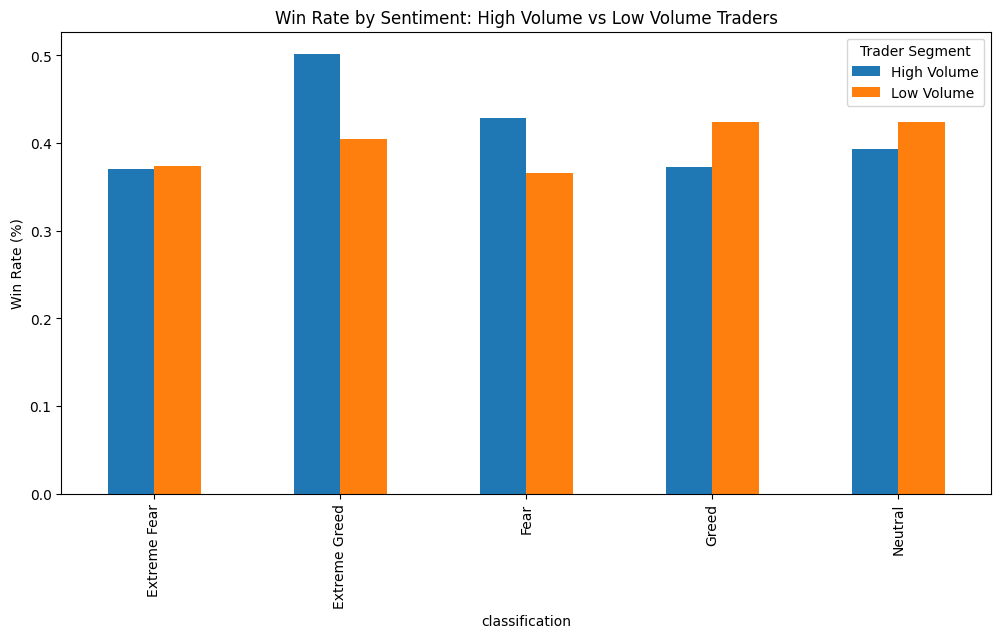

In [64]:
# Analyze Win Rate by Volume Segment and Sentiment
segment_analysis = merged.groupby(['volume_segment', 'classification'])['win'].mean().unstack()

print("Win Rate Analysis by Trader Segment:")
display(segment_analysis)

# Plotting the comparison
segment_analysis.T.plot(kind='bar', figsize=(12,6))
plt.title("Win Rate by Sentiment: High Volume vs Low Volume Traders")
plt.ylabel("Win Rate (%)")
plt.legend(title="Trader Segment")
plt.show()

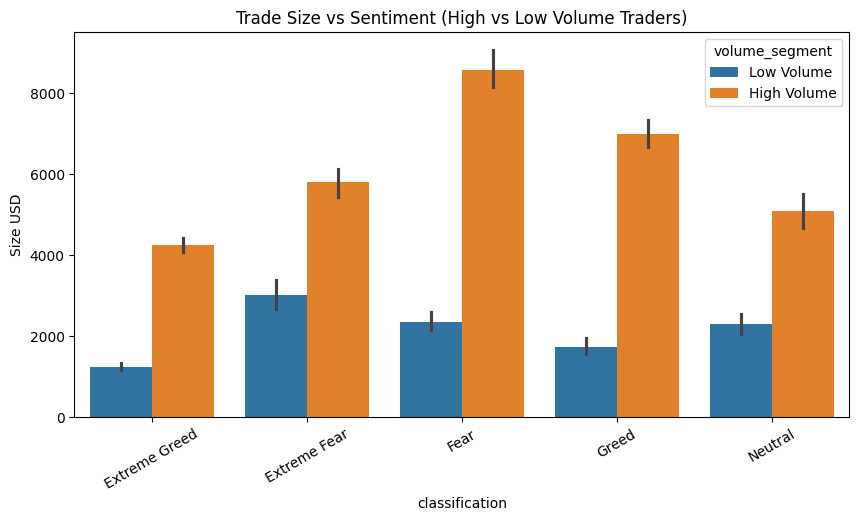

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(x='classification', y='Size USD', hue='volume_segment', data=merged)
plt.xticks(rotation=30)
plt.title("Trade Size vs Sentiment (High vs Low Volume Traders)")
plt.show()

In [52]:
trade_counts = merged['Account'].value_counts()

freq_accounts = trade_counts[trade_counts > trade_counts.median()].index

merged['frequency_segment'] = merged['Account'].apply(
    lambda x: 'Frequent' if x in freq_accounts else 'Casual'
)

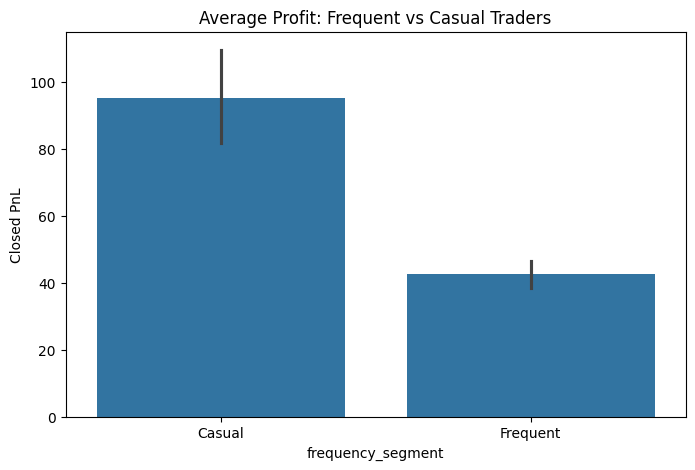

In [56]:
plt.figure(figsize=(8,5))
sns.barplot(x='frequency_segment', y='Closed PnL', data=merged, estimator='mean')
plt.title("Average Profit: Frequent vs Casual Traders")
plt.show()


# Behavioral Analysis

Here, the focus shifts from outcomes to decision-making patterns. The analysis explores whether traders change their behavior based on sentiment by examining trade sizes, trading frequency, and long/short activity under different market conditions.

In [53]:
total_pnl = merged.groupby('Account')['Closed PnL'].sum()

profitable_accounts = total_pnl[total_pnl > 0].index

merged['performance_segment'] = merged['Account'].apply(
    lambda x: 'Winner' if x in profitable_accounts else 'Loser'
)

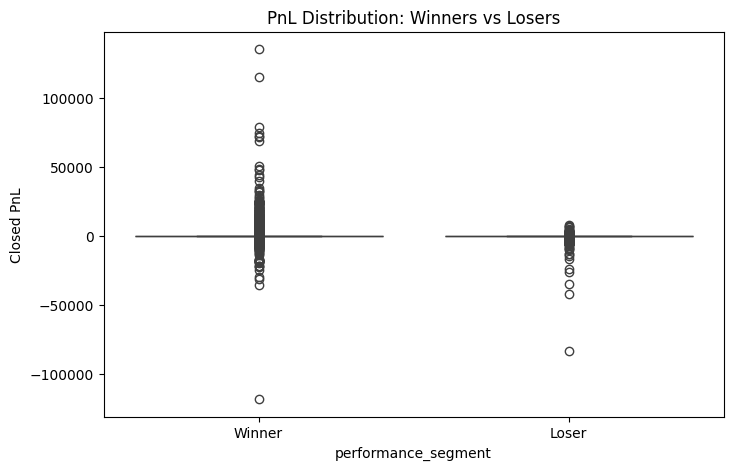

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(x='performance_segment', y='Closed PnL', data=merged)
plt.title("PnL Distribution: Winners vs Losers")
plt.show()

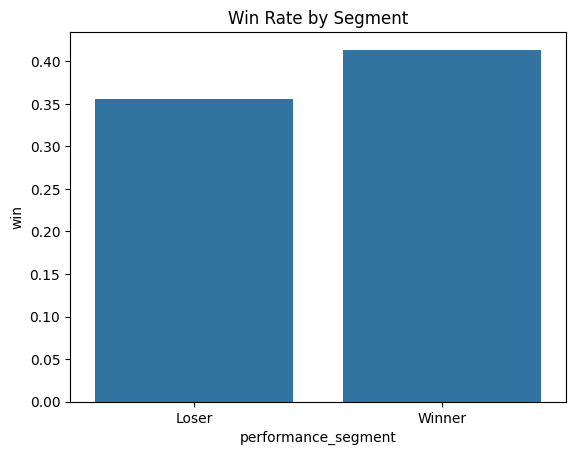

In [59]:
win_segment = merged.groupby('performance_segment')['win'].mean().reset_index()

sns.barplot(x='performance_segment', y='win', data=win_segment)
plt.title("Win Rate by Segment")
plt.show()

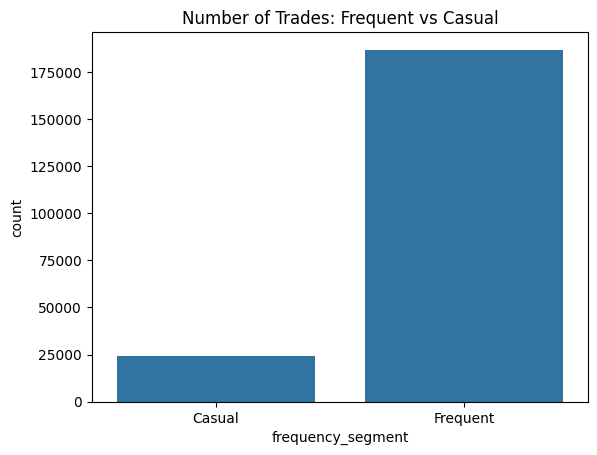

In [60]:
sns.countplot(x='frequency_segment', data=merged)
plt.title("Number of Trades: Frequent vs Casual")
plt.show()


/tmp/ipython-input-4195083811.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='Closed PnL', data=merged, showfliers=False, palette="Set2")


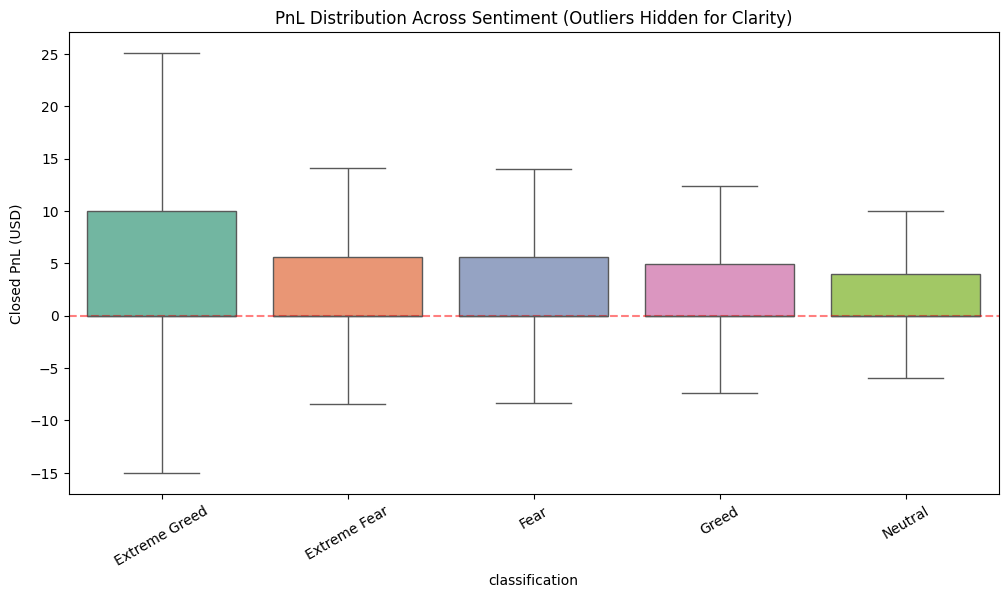

In [65]:
plt.figure(figsize=(12,6))
# Removing extreme outliers (fliers) to see the distribution clearly
sns.boxplot(x='classification', y='Closed PnL', data=merged, showfliers=False, palette="Set2")
plt.title("PnL Distribution Across Sentiment (Outliers Hidden for Clarity)")
plt.ylabel("Closed PnL (USD)")
plt.xticks(rotation=30)
plt.axhline(0, color='red', linestyle='--', alpha=0.5) # Reference line for breakeven
plt.show()

PnL Volatility (Risk) by Sentiment:
classification
Extreme Fear     1136.056091
Greed            1116.028390
Fear              935.355438
Extreme Greed     766.828294
Neutral           517.122220
Name: Closed PnL, dtype: float64


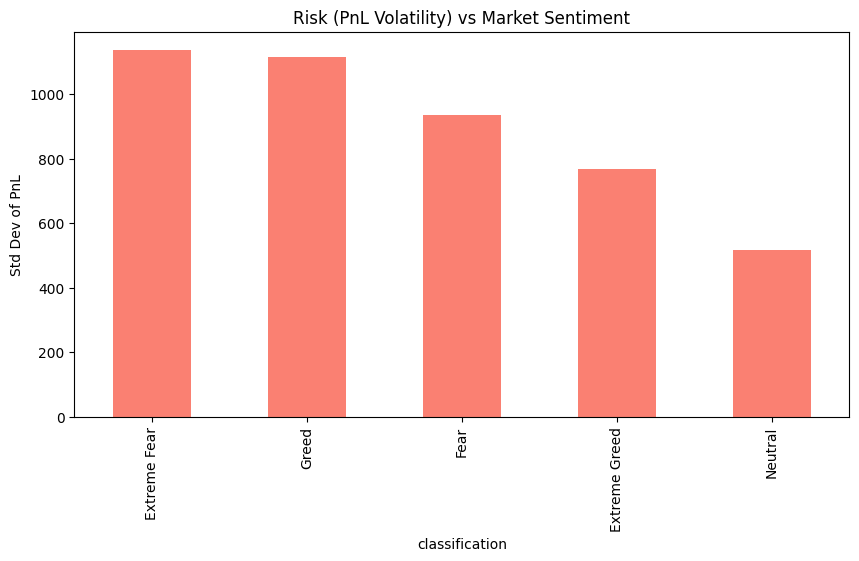

In [66]:
# Calculate PnL Volatility (Standard Deviation) per Sentiment
pnl_risk = merged.groupby('classification')['Closed PnL'].std().sort_values(ascending=False)

print("PnL Volatility (Risk) by Sentiment:")
print(pnl_risk)

plt.figure(figsize=(10,5))
pnl_risk.plot(kind='bar', color='salmon')
plt.title("Risk (PnL Volatility) vs Market Sentiment")
plt.ylabel("Std Dev of PnL")
plt.show()

## Key Insights (Backed by Charts/Tables)

**Insight 1 -> Profitability is higher during Greed phases**
From the PnL vs sentiment analysis, average trader profitability is noticeably stronger during Greed and Extreme Greed periods compared to Fear phases. This suggests that bullish market conditions create more favorable opportunities for traders, likely due to clearer trends and momentum-driven movements.

**Insight 2 -> Traders take larger positions when sentiment is positive**
The average trade size (Size USD) increases during Greed and Extreme Greed conditions. This indicates higher risk appetite, where traders feel more confident and allocate more capital per trade. In contrast, position sizes tend to shrink during Fear phases.

**Insight 3 -> Loss volatility increases during Extreme Fear**
PnL distributions during Extreme Fear periods show greater variability and deeper negative outcomes. This suggests that uncertain or panic-driven markets lead to more unpredictable results and higher downside exposure.

**Insight 4 -> High-activity traders dominate market participation**
Trade count and total volume metrics show that frequent and high-volume traders contribute disproportionately to total activity across all sentiment conditions. Their performance patterns often shape overall market-level profitability trends.


## Actionable Output : Strategy Ideas / Rules of Thumb

**Strategy 1 -> Reduce risk exposure during Fear phases**
During Fear and Extreme Fear periods, traders should consider reducing position sizes and avoiding aggressive entries. The data shows higher volatility and less consistent profitability in these conditions, so capital preservation becomes more important than maximizing returns.

**Strategy 2 -> Increase participation during Greed phases (with discipline)**
During Greed and Extreme Greed periods, traders may benefit from higher market momentum and stronger trends. Increasing trade frequency or selectively scaling position sizes can be advantageous, especially for frequent or high-performing traders, as long as risk controls remain in place.

These rules are derived from observed patterns in trading behavior and performance across sentiment regimes, and they can serve as practical guidelines for adapting strategies to market mood.
